# 0. 기본 정보
* 코드 작성자: 여서연
* 코드 작성일: 2025-04-17 ~
* 코드 작성 목적: LDA 토픽 모델링 구현

## 참조 코드 - Topic Modeling using LDA
* https://joyhong.tistory.com/138
* https://github.com/FifthSaint/NewsTextMining201903
* https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
* https://github.com/fastai/course-nlp/blob/master/2-svd-nmf-topic-modeling.ipynb

# 1. 기초 설정

## 사용 라이브러리

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import gensim
from gensim import corpora
from gensim.models import CoherenceModel

In [ ]:
import pyLDAvis
#import pyLDAvis.gensim
import pyLDAvis.gensim_models

In [4]:
import warnings
warnings.filterwarnings('ignore')

## 데이터 불러오기

In [5]:
df_cleaned_komoran = pd.read_csv("../data/cleaned_docs_komoran.csv", encoding='utf-8-sig')
df_cleaned_komoran['cleaned_doc'] = df_cleaned_komoran['cleaned_doc'].fillna('')
df_cleaned_komoran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cleaned_doc  798 non-null    object
dtypes: object(1)
memory usage: 6.4+ KB


In [6]:
df_cleaned_okt = pd.read_csv("../data/cleaned_docs_okt.csv", encoding='utf-8-sig')
df_cleaned_okt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cleaned_doc  798 non-null    object
dtypes: object(1)
memory usage: 6.4+ KB


In [7]:
terms_komoran = [doc.split() for doc in df_cleaned_komoran['cleaned_doc']]
print(terms_komoran[:5])
print(len(terms_komoran))

[['어장', '관리', '철학', '고찰', '최근', '한국', '사회', '유통', '시작', '신조어', '연인', '관계', '발전', '이전', '단계', '남녀', '관계', '뜻', '이해', '의미', '활동', '정체', '여전', '오리무중', '사람', '사람', '답변', '배경', '하', '필자', '미국', '철학자', '해리', '프랑크푸르트', '인간관', '의거', '의지', '불확정성', '개념', '도입', '개념', '본성', '포착', '필자', '제안', '상대방', '성적', '호감', '남녀', '만남', '시작', '자신', '의지', '불확정성', '과정', '핵심', '필자', '제안', '어장', '관리', '관계', '흥미', '시각', '제공', '논문', '말미', '논의'], ['인공', '지능', '인공', '감정', '감정', '기계', '실현', '인공', '감정', '철학', '탐구', '필요', '시점', '인간', '고유', '영역', '간주', '인지', '과제', '기계', '추월', '염려', '처지', '사람', '이성', '감정', '인간', '고유', '최근', '인공지능', '로봇', '감성', '작업', '화두', '글', '인공', '감정', '실현', '잠재', '위험', '논의', '감성', '로봇', '개발', '현황', '동기', '개괄', '로봇', '감정', '감정', '소유', '로봇', '검토', '감정', '선험', '정의', '감정', '수행', '핵심', '역할', '소개', '대상', '감정', '부여', '기준', '제안', '기준', '감정', '로봇', '미래', '실현', '주장', '감정', '소유', '로봇', '등장', '이전', '정도', '자율', '로봇', '일방', '감정', '소통', '잠재', '위험', '대비', '주장'], ['논문', '철회', '관음', '충', '발생학', '한국', '남성성', '완전', '변태', '과

In [8]:
doc_lengths_komoran = [len(doc) for doc in terms_komoran]

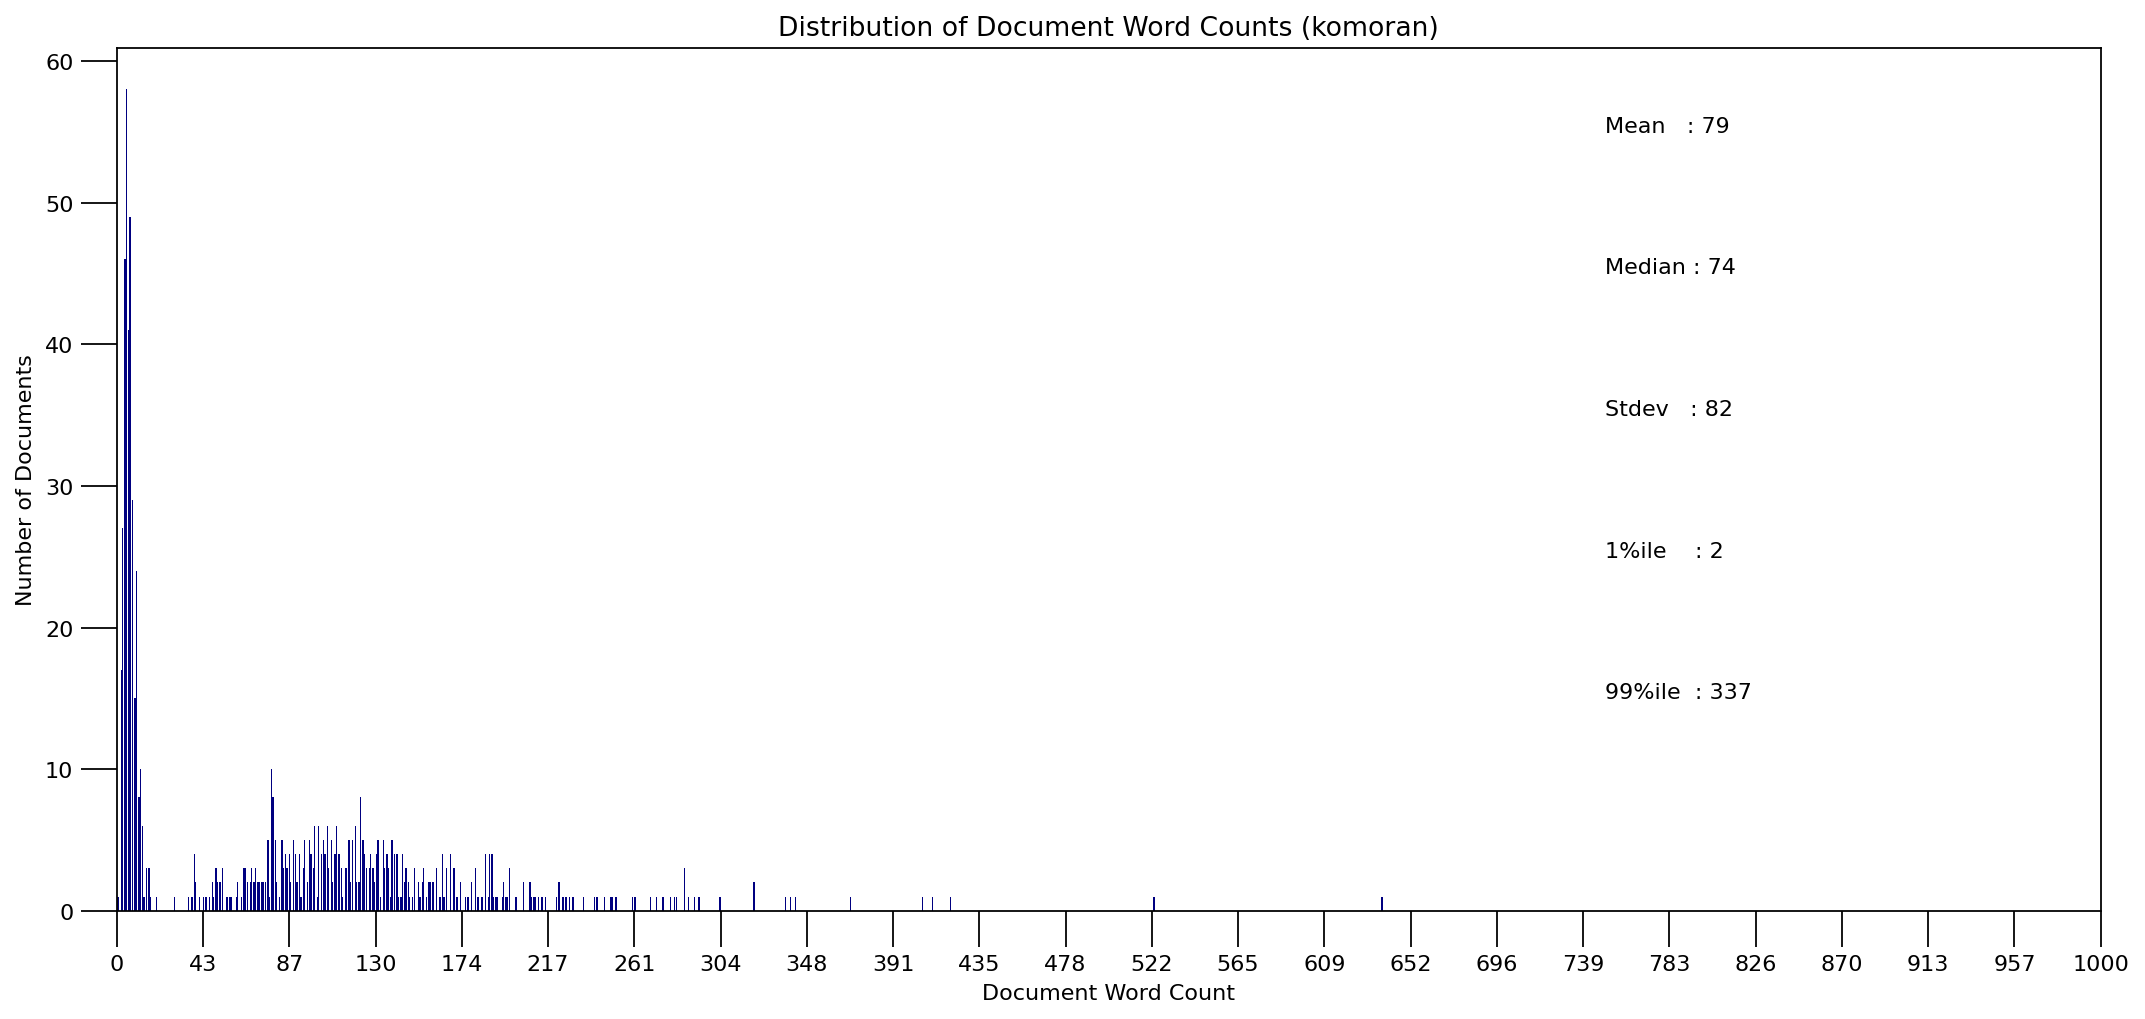

In [ ]:
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lengths_komoran, bins = 1000, color='navy')
plt.text(750, 55, "Mean   : " + str(round(np.mean(doc_lengths_komoran))))
plt.text(750, 45, "Median : " + str(round(np.median(doc_lengths_komoran))))
plt.text(750, 35, "Stdev   : " + str(round(np.std(doc_lengths_komoran))))
plt.text(750, 25, "1%ile    : " + str(round(np.quantile(doc_lengths_komoran, q=0.01))))
plt.text(750, 15, "99%ile  : " + str(round(np.quantile(doc_lengths_komoran, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,24))
plt.title('Distribution of Document Word Counts (komoran)')
plt.show()

In [10]:
# 최소 토큰 길이 문서 제거
terms_komoran = [doc for doc in terms_komoran if len(doc) > 4]
doc_lengths_komoran = [len(doc) for doc in terms_komoran]

print(f"평균 길이: {np.mean(doc_lengths_komoran):.2f}, 최소: {np.min(doc_lengths_komoran)}, 최대: {np.max(doc_lengths_komoran)}")
print(len(terms_komoran))

평균 길이: 88.80, 최소: 5, 최대: 638
706


In [11]:
terms_okt = [doc.split() for doc in df_cleaned_okt['cleaned_doc']]
print(terms_okt[:5])
print(len(terms_okt))

[['썸', '어장', '관리', '철학', '고찰', '최근', '한국', '사회', '유통', '시작', '신조어', '썸', '본격', '연인', '관계', '발전', '이전', '단계', '남녀', '관계', '뜻', '이해', '의미', '썸', '활동', '정체', '여전', '오리무중', '열', '사람', '열', '사람', '모두', '답변', '배경', '하', '필자', '미국', '철학자', '해리', '프랑크푸르트', '의', '인간', '관', '의거', '의지', '불확정성', '개념', '도입', '개념', '썸', '본성', '포착', '필자', '제안', '상대방', '성적', '호감', '남녀', '만남', '시작', '자신', '의지', '불확정성', '대하', '서로', '과정', '썸', '핵심', '썸', '필자', '제안', '썸', '어장', '관리', '관계', '시각', '제공', '대해', '논문', '말미', '상세', '논의'], ['인공', '지능', '인공', '감정', '감정', '기계', '실현', '인공', '감정', '관', '철학', '탐구', '시점', '인간', '고유', '영역', '간주', '인지', '과제', '기계', '추월', '염려', '처지', '사람', '이제', '이성', '감정', '인간', '유성', '최근', '인공', '지능', '로봇', '감성', '불어', '작업', '화두', '글', '인공', '감정', '실현', '가능성', '잠재', '위험', '논의', '먼저', '감성', '로봇', '개발', '현황', '주요한', '동기', '개괄', '왜', '로봇', '감정', '감정', '소유', '로봇', '검토', '감정', '선', '정의', '감정', '수행', '핵심', '역할', '소개', '이로', '대상', '감정', '부여', '기준', '제안', '기준', '감정', '로봇', '미래', '실현', '가능성', '주장', '감정', '소유', '

In [12]:
doc_lengths_okt = [len(doc) for doc in terms_okt]

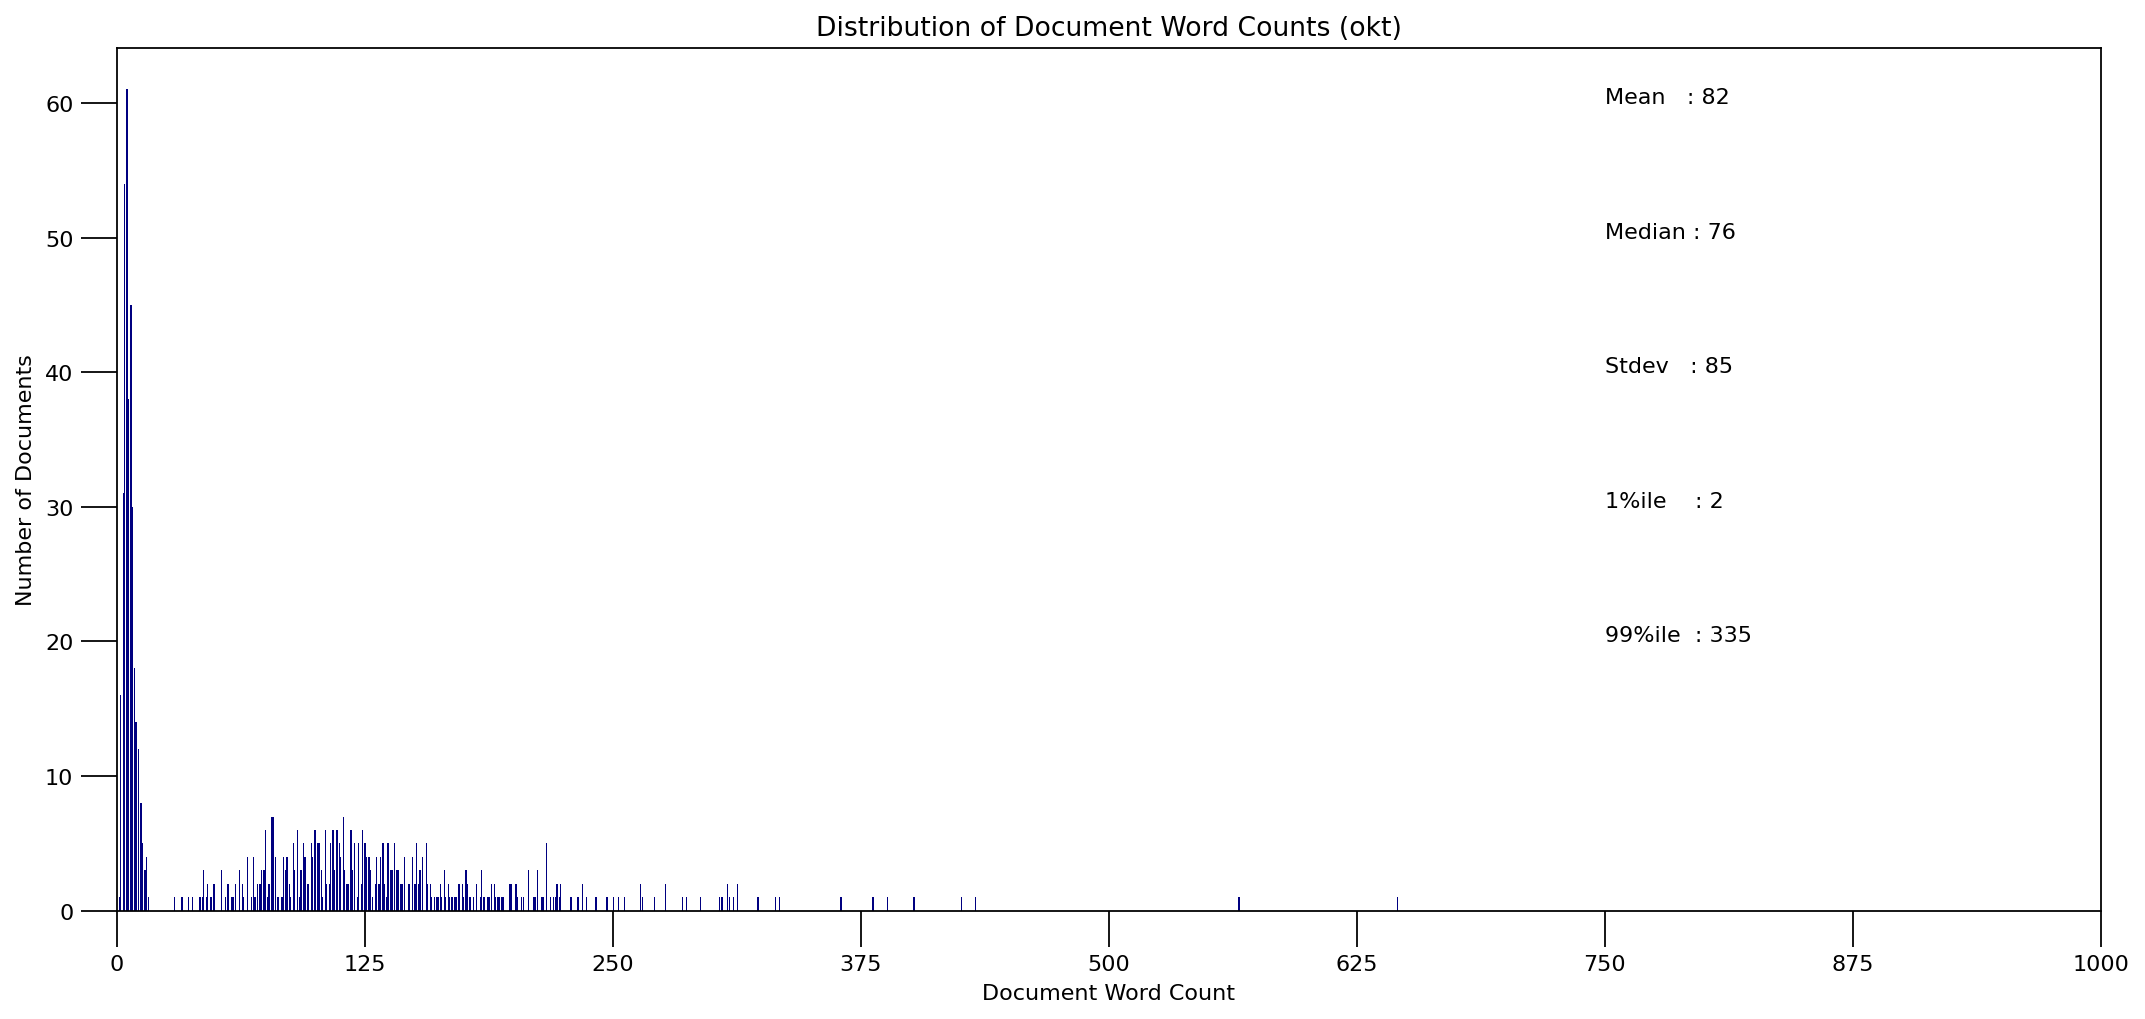

In [ ]:
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lengths_okt, bins = 1000, color='navy')
plt.text(750, 60, "Mean   : " + str(round(np.mean(doc_lengths_okt))))
plt.text(750, 50, "Median : " + str(round(np.median(doc_lengths_okt))))
plt.text(750, 40, "Stdev   : " + str(round(np.std(doc_lengths_okt))))
plt.text(750, 30, "1%ile    : " + str(round(np.quantile(doc_lengths_okt, q=0.01))))
plt.text(750, 20, "99%ile  : " + str(round(np.quantile(doc_lengths_okt, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts (okt)')
plt.show()

In [14]:
# 최소 토큰 길이 문서 제거
terms_okt = [doc for doc in terms_okt if len(doc) > 4]
doc_lengths_okt = [len(doc) for doc in terms_okt]

print(f"평균 길이: {np.mean(doc_lengths_okt):.2f}, 최소: {np.min(doc_lengths_okt)}, 최대: {np.max(doc_lengths_okt)}")
print(len(doc_lengths_okt))

평균 길이: 93.73, 최소: 5, 최대: 646
696


# 2. 사전과 문서-단어행렬 생성

In [15]:
# dictionary 생성
dictionary_komoran = corpora.Dictionary(terms_komoran)
dictionary_okt = corpora.Dictionary(terms_okt)

In [16]:
print(dictionary_komoran)
print(dictionary_okt)

Dictionary<6846 unique tokens: ['개념', '고찰', '과정', '관계', '관리']...>
Dictionary<7126 unique tokens: ['개념', '고찰', '과정', '관', '관계']...>


In [17]:
# 빈도 수 필터링
# 2개 미만의 문서에만 등장하거나 전체 문서의 50% 이상 등장하는 경우 제외
dictionary_komoran.filter_extremes(no_below=2, no_above=0.5)
dictionary_okt.filter_extremes(no_below=2, no_above=0.5)

In [18]:
print(dictionary_komoran)
print(dictionary_okt)

Dictionary<3420 unique tokens: ['개념', '고찰', '과정', '관계', '관리']...>
Dictionary<3528 unique tokens: ['개념', '고찰', '과정', '관', '관계']...>


In [19]:
# 문서-단어 행렬(document-term matrix) 생성
corpus_komoran = [dictionary_komoran.doc2bow(term) for term in terms_komoran]
corpus_okt = [dictionary_okt.doc2bow(term) for term in terms_okt]

In [20]:
print(corpus_komoran)
print(corpus_okt)

[[(0, 2), (1, 1), (2, 1), (3, 3), (4, 2), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 3), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1)], [(7, 1), (18, 1), (30, 1), (35, 1), (36, 1), (38, 1), (43, 1), (46, 1), (47, 2), (48, 13), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 2), (56, 2), (57, 1), (58, 1), (59, 1), (60, 1), (61, 7), (62, 1), (63, 1), (64, 1), (65, 2), (66, 1), (67, 1), (68, 1), (69, 3), (70, 1), (71, 1), (72, 1), (73, 2), (74, 1), (75, 2), (76, 4), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 2), (83, 1), (84, 1), (85, 2), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1)], [(1, 4), (2, 4), (6, 1), (7, 1), (8, 2), (13, 1), (15, 1), (19, 5), (28, 1), (40, 2), (42, 2), (56, 1), (82, 2), (

# 3. LDA 토픽 모델링 구현

## A. LDA 분석

In [21]:
NUM_TOPICS = 8 # DBpia 대분류(학문) 개수
TOP_N = 20

In [22]:
model_komoran = gensim.models.LdaModel(
    num_topics=NUM_TOPICS, # 출력 토픽 수
    corpus=corpus_komoran,
    id2word=dictionary_komoran,
    alpha='auto',
    eta='auto',
    passes=20,
    iterations=100,
    random_state=42
)

In [23]:
model_okt = gensim.models.LdaModel(
    num_topics=NUM_TOPICS, # 출력 토픽 수
    corpus=corpus_okt,
    id2word=dictionary_okt,
    alpha='auto',
    eta='auto',
    passes=20,
    iterations=100,
    random_state=42
)

In [24]:
# 각 토픽과 그 토픽에 속하는 단어를 중요도(확률)와 함께 출력
# num_topics: 출력할 토픽 개수 (default = 모델에 설정된 전체 토픽 수)
# num_words: 각 토픽 당 출력할 상위 단어 수
# formatted: True이면 문자열 형태로, False이면 튜플 형태로 반환

topics_komoran = model_komoran.show_topics(num_words=TOP_N, formatted=False)
topics_okt = model_okt.show_topics(num_words=TOP_N, formatted=False)

In [25]:
for topic_num, words in topics_komoran:
    print(f"토픽 {topic_num}:")
    for word, prob in words:
        print(f"  {word} ({prob:.3f})")

토픽 0:
  디자인 (0.031)
  사용자 (0.014)
  경험 (0.012)
  기능 (0.011)
  서비스 (0.009)
  사회 (0.009)
  아이돌 (0.009)
  가치 (0.009)
  개념 (0.008)
  기업 (0.007)
  중심 (0.007)
  시스템 (0.007)
  건강 (0.006)
  필요 (0.006)
  유형 (0.006)
  과정 (0.006)
  추천 (0.006)
  교육 (0.006)
  갈등 (0.006)
  제공 (0.006)
토픽 1:
  동물 (0.011)
  노인 (0.011)
  환경 (0.010)
  인간 (0.010)
  실험 (0.008)
  안락사 (0.007)
  물질 (0.007)
  사회 (0.006)
  정책 (0.006)
  음악 (0.005)
  현실 (0.005)
  필요 (0.005)
  경우 (0.005)
  신규 (0.005)
  생명 (0.005)
  사고 (0.005)
  방사능 (0.004)
  뇌 (0.004)
  세계 (0.004)
  제시 (0.004)
토픽 2:
  기술 (0.028)
  인공지능 (0.020)
  산업 (0.017)
  인간 (0.016)
  사회 (0.014)
  윤리 (0.012)
  활용 (0.009)
  분야 (0.008)
  유전자 (0.008)
  데이터 (0.008)
  교육 (0.008)
  변화 (0.008)
  혁명 (0.008)
  시대 (0.008)
  논문 (0.007)
  개발 (0.007)
  필요 (0.007)
  발전 (0.006)
  예술 (0.006)
  생명 (0.006)
토픽 3:
  활성 (0.011)
  균 (0.011)
  항산 (0.010)
  서비스 (0.009)
  이용 (0.008)
  기능 (0.008)
  사용 (0.007)
  간호사 (0.007)
  항균 (0.006)
  함량 (0.006)
  세대 (0.005)
  유산 (0.005)
  능 (0.005)
  추출물 (0.005)
  활

In [26]:
for topic_num, words in topics_okt:
    print(f"토픽 {topic_num}:")
    for word, prob in words:
        print(f"  {word} ({prob:.3f})")

토픽 0:
  사회 (0.014)
  정책 (0.011)
  범죄 (0.009)
  코로나 (0.009)
  문화 (0.008)
  세대 (0.008)
  소년 (0.008)
  방안 (0.008)
  집단 (0.006)
  중심 (0.006)
  유형 (0.006)
  체계 (0.005)
  환경 (0.005)
  제시 (0.005)
  보호 (0.005)
  형사 (0.005)
  지원 (0.004)
  연령 (0.004)
  행복 (0.004)
  아동 (0.004)
토픽 1:
  사회 (0.011)
  변화 (0.009)
  유전자 (0.009)
  기술 (0.009)
  교육 (0.008)
  문화 (0.008)
  디자인 (0.007)
  한국 (0.007)
  시대 (0.007)
  사용 (0.006)
  중심 (0.006)
  편집 (0.005)
  세대 (0.005)
  대해 (0.005)
  치료 (0.005)
  과정 (0.005)
  소비 (0.004)
  인간 (0.004)
  제시 (0.004)
  지역 (0.004)
토픽 2:
  사회 (0.013)
  뉴스 (0.008)
  의미 (0.007)
  가짜 (0.007)
  인간 (0.006)
  의 (0.006)
  주의 (0.006)
  감정 (0.005)
  관계 (0.005)
  변화 (0.005)
  인식 (0.005)
  능력 (0.005)
  정치 (0.005)
  과정 (0.004)
  청년 (0.004)
  후기 (0.004)
  유산균 (0.004)
  감정노동 (0.004)
  고립 (0.004)
  죽음 (0.004)
토픽 3:
  인공 (0.025)
  지능 (0.025)
  기술 (0.021)
  섭취 (0.012)
  인간 (0.011)
  카페인 (0.010)
  활용 (0.008)
  사회 (0.007)
  윤리 (0.007)
  개발 (0.006)
  분야 (0.006)
  가장 (0.006)
  스트레스 (0.005)
  수면 (0.005)
  사용 (

In [27]:
word_dict_komoran = {}
word_dict_okt = {}

In [28]:
for i in range(NUM_TOPICS):
  words_komoran = model_komoran.show_topic(i, topn=TOP_N)
  word_dict_komoran['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words_komoran]
  word_df_komoran = pd.DataFrame(word_dict_komoran)

In [29]:
for i in range(NUM_TOPICS):
  words_okt = model_okt.show_topic(i, topn=TOP_N)
  word_dict_okt['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words_okt]
  word_df_okt = pd.DataFrame(word_dict_okt)

In [30]:
word_df_komoran

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08
0,디자인,동물,기술,활성,스트레스,사회,식품,메타버스
1,사용자,노인,인공지능,균,간호사,문화,카페인,콘텐츠
2,경험,환경,산업,항산,대학생,뉴스,섭취,플라스틱
3,기능,인간,인간,서비스,사용,청소년,증가,세계
4,서비스,실험,사회,이용,간호,가짜,교육,플랫폼
5,사회,안락사,윤리,기능,직무,범죄,변화,변화
6,아이돌,물질,활용,사용,관계,표현,감소,산업
7,가치,사회,분야,간호사,광고,소년,음료,중심
8,개념,정책,유전자,항균,수면,난민,영양,사례
9,기업,음악,데이터,함량,대상,자살,섭취량,활용


In [31]:
word_df_okt

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08
0,사회,사회,사회,인공,플라스틱,청소년,간호사,서비스
1,정책,변화,뉴스,지능,물질,스트레스,식품,버스
2,범죄,유전자,의미,기술,아이돌,요인,교육,메타
3,코로나,기술,가짜,섭취,항산화,이용,기능,사용자
4,문화,교육,인간,인간,노인,대학생,직무,콘텐츠
5,세대,문화,의,카페인,활,사용,의,디자인
6,소년,디자인,주의,활용,산업,간호,변화,기능
7,방안,한국,감정,사회,환경,온라인,증가,플랫폼
8,집단,시대,관계,윤리,추출,브랜드,환경,세계
9,중심,사용,변화,개발,증가,인터넷,신규,경험


In [32]:
model_komoran.print_topics(num_words=10)

[(0,
  '0.031*"디자인" + 0.014*"사용자" + 0.012*"경험" + 0.011*"기능" + 0.009*"서비스" + 0.009*"사회" + 0.009*"아이돌" + 0.009*"가치" + 0.008*"개념" + 0.007*"기업"'),
 (1,
  '0.011*"동물" + 0.011*"노인" + 0.010*"환경" + 0.010*"인간" + 0.008*"실험" + 0.007*"안락사" + 0.007*"물질" + 0.006*"사회" + 0.006*"정책" + 0.005*"음악"'),
 (2,
  '0.028*"기술" + 0.020*"인공지능" + 0.017*"산업" + 0.016*"인간" + 0.014*"사회" + 0.012*"윤리" + 0.009*"활용" + 0.008*"분야" + 0.008*"유전자" + 0.008*"데이터"'),
 (3,
  '0.011*"활성" + 0.011*"균" + 0.010*"항산" + 0.009*"서비스" + 0.008*"이용" + 0.008*"기능" + 0.007*"사용" + 0.007*"간호사" + 0.006*"항균" + 0.006*"함량"'),
 (4,
  '0.020*"스트레스" + 0.015*"간호사" + 0.011*"대학생" + 0.011*"사용" + 0.011*"간호" + 0.011*"직무" + 0.009*"관계" + 0.008*"광고" + 0.007*"수면" + 0.007*"대상"'),
 (5,
  '0.019*"사회" + 0.011*"문화" + 0.009*"뉴스" + 0.009*"청소년" + 0.007*"가짜" + 0.007*"범죄" + 0.007*"표현" + 0.006*"소년" + 0.006*"난민" + 0.006*"자살"'),
 (6,
  '0.020*"식품" + 0.018*"카페인" + 0.016*"섭취" + 0.016*"증가" + 0.013*"교육" + 0.012*"변화" + 0.010*"감소" + 0.009*"음료" + 0.009*"영양" + 0.008*"섭취량"'),
 (7,
  '0.

In [33]:
model_okt.print_topics(num_words=10)

[(0,
  '0.014*"사회" + 0.011*"정책" + 0.009*"범죄" + 0.009*"코로나" + 0.008*"문화" + 0.008*"세대" + 0.008*"소년" + 0.008*"방안" + 0.006*"집단" + 0.006*"중심"'),
 (1,
  '0.011*"사회" + 0.009*"변화" + 0.009*"유전자" + 0.009*"기술" + 0.008*"교육" + 0.008*"문화" + 0.007*"디자인" + 0.007*"한국" + 0.007*"시대" + 0.006*"사용"'),
 (2,
  '0.013*"사회" + 0.008*"뉴스" + 0.007*"의미" + 0.007*"가짜" + 0.006*"인간" + 0.006*"의" + 0.006*"주의" + 0.005*"감정" + 0.005*"관계" + 0.005*"변화"'),
 (3,
  '0.025*"인공" + 0.025*"지능" + 0.021*"기술" + 0.012*"섭취" + 0.011*"인간" + 0.010*"카페인" + 0.008*"활용" + 0.007*"사회" + 0.007*"윤리" + 0.006*"개발"'),
 (4,
  '0.011*"플라스틱" + 0.010*"물질" + 0.009*"아이돌" + 0.009*"항산화" + 0.009*"노인" + 0.009*"활" + 0.008*"산업" + 0.008*"환경" + 0.008*"추출" + 0.007*"증가"'),
 (5,
  '0.016*"청소년" + 0.015*"스트레스" + 0.013*"요인" + 0.013*"이용" + 0.012*"대학생" + 0.012*"사용" + 0.010*"간호" + 0.009*"온라인" + 0.009*"브랜드" + 0.008*"인터넷"'),
 (6,
  '0.016*"간호사" + 0.010*"식품" + 0.009*"교육" + 0.009*"기능" + 0.008*"직무" + 0.008*"의" + 0.008*"변화" + 0.007*"증가" + 0.006*"환경" + 0.006*"신규"'),
 (7,
  '0.018*

In [34]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)

for i in range(5):
    print(model_komoran.get_document_topics(corpus_komoran)[i])
print()
for i in range(5):
    print(model_okt.get_document_topics(corpus_okt)[i])

[(0, 0.9943569)]
[(2, 0.5655603), (4, 0.4313974)]
[(1, 0.1447547), (2, 0.7296541), (5, 0.12410969)]
[(1, 0.3923382), (2, 0.2753119), (6, 0.12318369), (7, 0.20766231)]
[(0, 0.19210139), (7, 0.77785957)]

[(2, 0.99580914)]
[(2, 0.3769734), (3, 0.62020147)]
[(2, 0.20076615), (4, 0.7976227)]
[(1, 0.010272321), (3, 0.011268994), (6, 0.94082826)]
[(3, 0.9975786)]


## B. pyLDAvis를 이용한 시각화

In [35]:
pyLDAvis.enable_notebook()

In [36]:
#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)

In [37]:
data_komoran = pyLDAvis.gensim_models.prepare(model_komoran, corpus_komoran, dictionary_komoran)
data_komoran

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.130163 -0.003710       1        1  16.957606
7      0.097258 -0.067839       2        1  13.127937
1      0.026468  0.079414       3        1  12.653257
4     -0.069044  0.059420       4        1  12.497283
5      0.085242  0.113973       5        1  12.356076
3     -0.098639 -0.159630       6        1  11.212147
6     -0.219375  0.057399       7        1  11.022158
0      0.047927 -0.079028       8        1  10.173536, topic_info=      Term        Freq       Total Category  logprob  loglift
2135   디자인  187.000000  187.000000  Default  30.0000  30.0000
77    인공지능  199.000000  199.000000  Default  29.0000  29.0000
187     기술  344.000000  344.000000  Default  28.0000  28.0000
1888  스트레스  176.000000  176.000000  Default  27.0000  27.0000
2311   카페인  131.000000  131.000000  Default  26.0000  26.0000
...    ...         ...         ...      ...      ...      ...
177     활용   31.287753  228.795453   Topic8  -5.2306   0.2958
147     제시   29.307942  188.322900   Topic8  -5.2960   0.4251
50      개발   29.349257  201.274807   Topic8  -5.2945   0.3600
261     사례   26.152130  137.051829   Topic8  -5.4099   0.6290
994     방안   25.193244  131.821380   Topic8  -5.4472   0.6305

[526 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2952      6  0.972294    -2
2618      2  0.922428    10
2568      8  0.841714   10대
1722      1  0.069673    3D
1722      2  0.905752    3D
...     ...       ...   ...
247       8  0.075549     후
1227      2  0.027064    후기
1227      5  0.811919    후기
1227      7  0.135320    후기
2639      3  0.972732  후쿠시마

[1414 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 2, 5, 6, 4, 7, 1])

In [38]:
data_okt = pyLDAvis.gensim_models.prepare(model_okt, corpus_okt, dictionary_okt)
data_okt

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.089399 -0.015881       1        1  16.574124
3     -0.011597 -0.025116       2        1  15.358718
6     -0.161824 -0.020500       3        1  15.308160
4     -0.134369 -0.097428       4        1  11.905221
2      0.090754 -0.078585       5        1  11.876520
7      0.061766  0.055056       6        1  10.953444
5     -0.043716  0.205760       7        1   9.468582
0      0.109586 -0.023306       8        1   8.555231, topic_info=     Term        Freq       Total Category  logprob  loglift
93     인공  233.000000  233.000000  Default  30.0000  30.0000
103    지능  233.000000  233.000000  Default  29.0000  29.0000
872    버스  109.000000  109.000000  Default  28.0000  28.0000
1318  간호사  169.000000  169.000000  Default  27.0000  27.0000
871    메타  108.000000  108.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
0      개념   20.306645  133.946283   Topic8  -5.5291   0.5721
311    인식   19.296630  136.666439   Topic8  -5.5801   0.5010
437   콘텐츠   19.476258  151.491334   Topic8  -5.5708   0.4073
68     기준   17.876664   74.832025   Topic8  -5.6565   1.0269
3       관   17.734098  141.717200   Topic8  -5.6645   0.3803

[542 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2815      3  0.922574    가공
1784      8  0.883120    가문
866       5  0.266687    가상
866       6  0.711164    가상
1359      1  0.943443    가위
...     ...       ...   ...
1316      4  0.110175    후기
1316      5  0.826310    후기
2758      4  0.908976  후쿠시마
2758      8  0.082634  후쿠시마
3430      1  0.958806    흥행

[1468 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 7, 5, 3, 8, 6, 1])

# 4. 평가

In [39]:
coherence_model_komoran = CoherenceModel(
    model=model_komoran,
    texts=terms_komoran,
    dictionary=dictionary_komoran,
    topn=TOP_N,
    coherence='c_v'
    )
coherence_model_okt = CoherenceModel(
    model=model_okt,
    texts=terms_okt,
    dictionary=dictionary_okt,
    topn=TOP_N,
    coherence='c_v'
    )

In [40]:
print('Log Perplexity: ', model_komoran.log_perplexity(corpus_komoran))
print('\nCoherence Score: ', coherence_model_komoran.get_coherence())

Log Perplexity:  -7.1483264391781685

Coherence Score:  0.3814347019152025


In [41]:
print('Log Perplexity: ', model_okt.log_perplexity(corpus_okt))
print('\nCoherence Score: ', coherence_model_okt.get_coherence())

Log Perplexity:  -7.223193519100036

Coherence Score:  0.34336003286301764


# 5. 하이퍼파라미터 조정

## A. LDA 토픽 개수 지정

### a. Perplexity - 낮을수록 좋음

In [42]:
perplexity_values_komoran = []
perplexity_values_okt = []

In [43]:
for i in range(2, 10):
    ldamodel_komoran = gensim.models.ldamodel.LdaModel(
        num_topics=i,
        corpus=corpus_komoran,
        id2word = dictionary_komoran,
        alpha='auto',
        eta='auto',
        passes=20,
        iterations=100,
        random_state=42
        )
    perplexity_values_komoran.append(ldamodel_komoran.log_perplexity(corpus_komoran))

In [44]:

for i in range(2, 10):
    ldamodel_okt = gensim.models.ldamodel.LdaModel(
        num_topics=i,
        corpus=corpus_okt,
        id2word = dictionary_okt,
        alpha='auto',
        eta='auto',
        passes=20,
        iterations=100,
        random_state=42
        )
    perplexity_values_okt.append(ldamodel_okt.log_perplexity(corpus_okt))

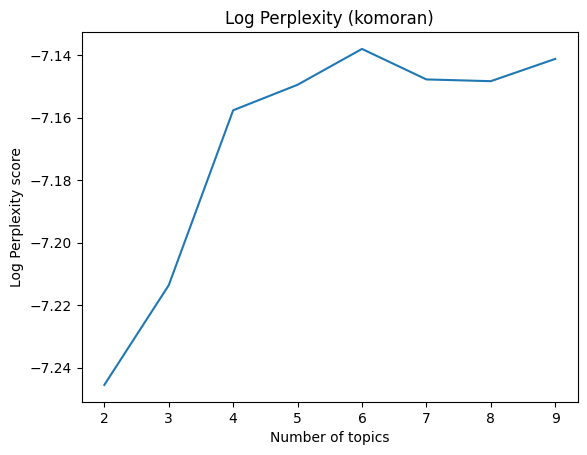

In [45]:
x = range(2, 10)
plt.plot(x, perplexity_values_komoran)
plt.title('Log Perplexity (komoran)')
plt.xlabel("Number of topics")
plt.ylabel("Log Perplexity score")
plt.show()

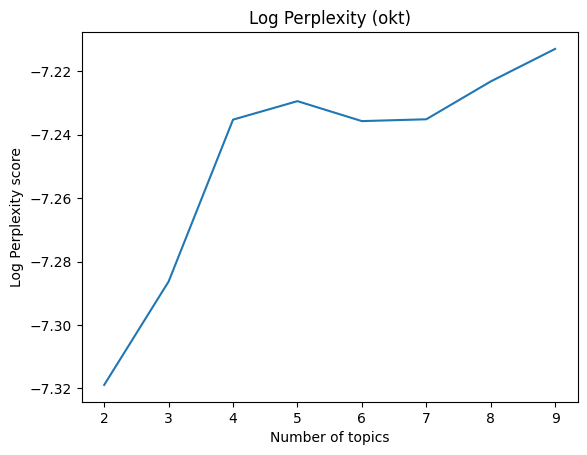

In [46]:
x = range(2, 10)
plt.plot(x, perplexity_values_okt)
plt.title('Log Perplexity (okt)')
plt.xlabel("Number of topics")
plt.ylabel("Log Perplexity score")
plt.show()

### b. Coherence - 높을수록 좋음

In [47]:
coherence_values_komoran = []
coherence_values_okt = []

In [48]:
for i in range(2, 10):
    ldamodel_komoran = gensim.models.ldamodel.LdaModel(
        num_topics=i,
        corpus=corpus_komoran,
        id2word=dictionary_komoran,
        alpha='auto',
        eta='auto',
        passes=20,
        iterations=100,
        random_state=42
        )
    coherence_model_komoran = CoherenceModel(
        model=ldamodel_komoran,
        texts=terms_komoran,
        dictionary=dictionary_komoran,
        topn=TOP_N,
        coherence='c_v'
        )
    coherence_values_komoran.append(coherence_model_komoran.get_coherence())

In [49]:
for i in range(2, 10):
    ldamodel_okt = gensim.models.ldamodel.LdaModel(
        num_topics=i,
        corpus=corpus_okt,
        id2word=dictionary_okt,
        alpha='auto',
        eta='auto',
        passes=20,
        iterations=100,
        random_state=42
        )
    coherence_model_okt = CoherenceModel(
        model=ldamodel_okt,
        texts=terms_okt,
        dictionary=dictionary_okt,
        topn=TOP_N,
        coherence='c_v'
        )
    coherence_values_okt.append(coherence_model_okt.get_coherence())

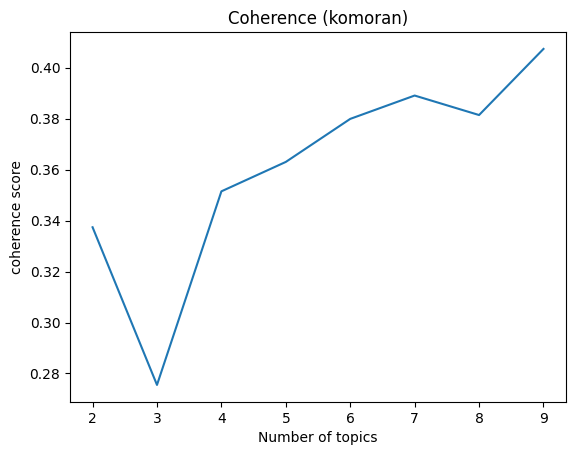

In [50]:
x = range(2, 10)
plt.plot(x, coherence_values_komoran)
plt.title('Coherence (komoran)')
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.show()

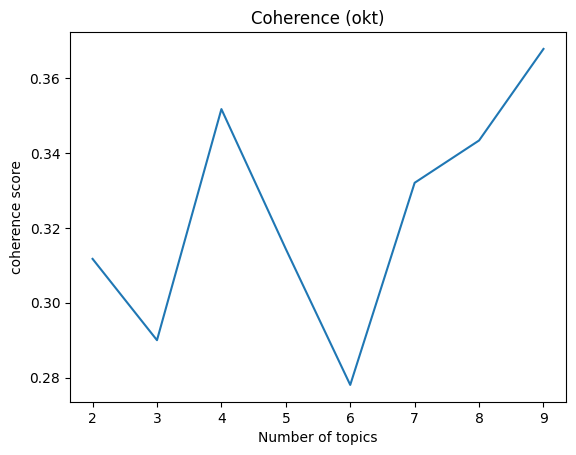

In [51]:
x = range(2, 10)
plt.plot(x, coherence_values_okt)
plt.title('Coherence (okt)')
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.show()

최종적으로 Perplexity와 Coherence Score를 동시에 고려하여 최적의 주제 수를 선택

## B. 최종 LDA 분석

In [ ]:
# Perplexity의 변곡점
# Coherence Score가 높은 값 중에 주관적으로 적절해 보이는 값 선정
NUM_TOPICS_komoran = 7
NUM_TOPICS_okt = 7

In [53]:
final_model_komoran = gensim.models.LdaModel(
    num_topics=NUM_TOPICS_komoran, # 출력 토픽 수
    corpus=corpus_komoran,
    id2word=dictionary_komoran,
        alpha='auto',
        eta='auto',
        passes=20,
        iterations=100,
    random_state=42
)

In [54]:
final_model_okt = gensim.models.LdaModel(
    num_topics=NUM_TOPICS_okt, # 출력 토픽 수
    corpus=corpus_okt,
    id2word=dictionary_okt,
        alpha='auto',
        eta='auto',
        passes=20,
        iterations=100,
    random_state=42
)

In [55]:
# 각 토픽과 그 토픽에 속하는 단어를 중요도(확률)와 함께 출력
final_topics_komoran = sorted(final_model_komoran.show_topics(num_words=TOP_N, formatted=False), key=lambda x: x[0])
final_topics_okt = sorted(final_model_okt.show_topics(num_words=TOP_N, formatted=False), key=lambda x: x[0])

In [56]:
for topic_num, words in final_topics_komoran:
    print(f"토픽 {topic_num}:")
    for word, prob in words:
        print(f"  {word} ({prob:.3f})")

토픽 0:
  디자인 (0.021)
  메타버스 (0.011)
  콘텐츠 (0.011)
  사용자 (0.011)
  경험 (0.010)
  중심 (0.010)
  서비스 (0.009)
  유형 (0.009)
  미디어 (0.009)
  아이돌 (0.008)
  기능 (0.008)
  활용 (0.007)
  소비 (0.007)
  플랫폼 (0.007)
  개념 (0.007)
  기업 (0.007)
  세계 (0.007)
  전략 (0.006)
  가치 (0.006)
  요인 (0.006)
토픽 1:
  환경 (0.011)
  노인 (0.010)
  플라스틱 (0.009)
  동물 (0.007)
  안락사 (0.007)
  인간 (0.006)
  해양 (0.006)
  경우 (0.006)
  물질 (0.006)
  정책 (0.006)
  신규 (0.006)
  필요 (0.006)
  변화 (0.005)
  미세먼지 (0.005)
  사회 (0.005)
  오염 (0.005)
  현실 (0.005)
  발생 (0.005)
  생명 (0.005)
  제시 (0.004)
토픽 2:
  기술 (0.028)
  인공지능 (0.019)
  산업 (0.019)
  인간 (0.016)
  사회 (0.013)
  윤리 (0.012)
  분야 (0.009)
  활용 (0.009)
  유전자 (0.009)
  교육 (0.008)
  변화 (0.008)
  시대 (0.008)
  데이터 (0.007)
  혁명 (0.007)
  코로나 (0.007)
  개발 (0.007)
  발전 (0.007)
  필요 (0.006)
  논문 (0.006)
  예술 (0.006)
토픽 3:
  활성 (0.011)
  균 (0.010)
  항산 (0.009)
  기능 (0.008)
  사용 (0.007)
  이용 (0.006)
  실험 (0.006)
  변화 (0.006)
  항균 (0.006)
  미세 (0.005)
  함량 (0.005)
  서비스 (0.005)
  개발 (0.005)
  세포 (0.

In [57]:
for topic_num, words in final_topics_okt:
    print(f"토픽 {topic_num}:")
    for word, prob in words:
        print(f"  {word} ({prob:.3f})")

토픽 0:
  버스 (0.015)
  메타 (0.015)
  사회 (0.014)
  문화 (0.010)
  유형 (0.009)
  정책 (0.008)
  코로나 (0.008)
  중심 (0.008)
  세대 (0.007)
  산업 (0.007)
  플랫폼 (0.007)
  세계 (0.007)
  콘텐츠 (0.007)
  범죄 (0.006)
  소년 (0.006)
  갈등 (0.006)
  방안 (0.006)
  집단 (0.005)
  기술 (0.004)
  소비 (0.004)
토픽 1:
  사회 (0.011)
  디자인 (0.010)
  기술 (0.008)
  서비스 (0.008)
  유전자 (0.007)
  한국 (0.007)
  변화 (0.007)
  문화 (0.006)
  교육 (0.006)
  사용 (0.006)
  사용자 (0.006)
  중심 (0.006)
  경험 (0.006)
  콘텐츠 (0.005)
  제시 (0.005)
  시대 (0.005)
  과정 (0.005)
  대해 (0.004)
  편집 (0.004)
  소비 (0.004)
토픽 2:
  사회 (0.010)
  의 (0.008)
  뉴스 (0.007)
  의미 (0.006)
  가짜 (0.006)
  인간 (0.006)
  관계 (0.005)
  감정 (0.005)
  간호사 (0.005)
  이미지 (0.005)
  활동 (0.004)
  능력 (0.004)
  변화 (0.004)
  이론 (0.004)
  인식 (0.004)
  후기 (0.004)
  정치 (0.004)
  세계 (0.004)
  항균 (0.004)
  발생 (0.004)
토픽 3:
  인공 (0.025)
  지능 (0.025)
  기술 (0.019)
  인간 (0.013)
  섭취 (0.013)
  카페인 (0.010)
  윤리 (0.008)
  개발 (0.007)
  스트레스 (0.007)
  활용 (0.006)
  가장 (0.006)
  수면 (0.005)
  사회 (0.005)
  능력 (0.005)
  

In [58]:
final_word_dict_komoran = {}
for i in range(NUM_TOPICS_komoran):
  final_words_komoran = final_model_komoran.show_topic(i, topn=TOP_N)
  final_word_dict_komoran['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in final_words_komoran]
  final_word_df_komoran = pd.DataFrame(final_word_dict_komoran)

In [59]:
final_word_dict_okt = {}
for i in range(NUM_TOPICS_okt):
  final_words_okt = final_model_okt.show_topic(i, topn=TOP_N)
  final_word_dict_okt['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in final_words_okt]
  final_word_df_okt = pd.DataFrame(final_word_dict_okt)

In [60]:
final_word_df_komoran

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,디자인,환경,기술,활성,스트레스,사회,식품
1,메타버스,노인,인공지능,균,간호사,문화,카페인
2,콘텐츠,플라스틱,산업,항산,사용,뉴스,섭취
3,사용자,동물,인간,기능,대학생,한국,교육
4,경험,안락사,사회,사용,직무,표현,증가
5,중심,인간,윤리,이용,간호,가짜,음료
6,서비스,해양,분야,실험,관계,청소년,변화
7,유형,경우,활용,변화,광고,정책,영양
8,미디어,물질,유전자,항균,청소년,교육,섭취량
9,아이돌,정책,교육,미세,사회,소년,감소


In [61]:
final_word_df_okt

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,버스,사회,사회,인공,플라스틱,청소년,간호사
1,메타,디자인,의,지능,물질,이용,기능
2,사회,기술,뉴스,기술,항산화,스트레스,교육
3,문화,서비스,의미,인간,아이돌,요인,식품
4,유형,유전자,가짜,섭취,노인,대학생,변화
5,정책,한국,인간,카페인,활,사용,직무
6,코로나,변화,관계,윤리,추출,온라인,의
7,중심,문화,감정,개발,환경,간호,증가
8,세대,교육,간호사,스트레스,산업,브랜드,환경
9,산업,사용,이미지,활용,증가,인터넷,경우


In [62]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)
for i in range(5):
    print(final_model_komoran.get_document_topics(corpus_komoran)[i])
print()
for i in range(5):
    print(final_model_okt.get_document_topics(corpus_okt)[i])

[(0, 0.38396856), (5, 0.61158925)]
[(2, 0.6463285), (4, 0.35090563)]
[(0, 0.09333792), (2, 0.05251799), (4, 0.012547728), (5, 0.840663)]
[(0, 0.13632903), (1, 0.40646124), (2, 0.30301493), (6, 0.15285283)]
[(0, 0.51067966), (5, 0.4611445)]

[(2, 0.9962494)]
[(2, 0.37973183), (3, 0.61779803)]
[(1, 0.17964366), (4, 0.81902367)]
[(1, 0.010951225), (3, 0.011153984), (6, 0.9452866)]
[(3, 0.9307287), (6, 0.06743181)]


## C. 최종 pyLDAvis 시각화

In [63]:
pyLDAvis.enable_notebook()

In [64]:
final_data_komoran = pyLDAvis.gensim_models.prepare(final_model_komoran, corpus_komoran, dictionary_komoran)
final_data_komoran

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.125335 -0.033191       1        1  18.118748
0      0.107224 -0.077919       2        1  15.909276
5      0.099496  0.096892       3        1  15.344935
4     -0.014305  0.111001       4        1  13.540411
1     -0.017378  0.007611       5        1  12.993981
3     -0.096059 -0.154587       6        1  12.452751
6     -0.204314  0.050192       7        1  11.639899, topic_info=      Term        Freq       Total Category  logprob  loglift
187     기술  344.000000  344.000000  Default  30.0000  30.0000
2135   디자인  194.000000  194.000000  Default  29.0000  29.0000
77    인공지능  199.000000  199.000000  Default  28.0000  28.0000
2311   카페인  129.000000  129.000000  Default  27.0000  27.0000
837     식품  169.000000  169.000000  Default  26.0000  26.0000
...    ...         ...         ...      ...      ...      ...
181     경우   36.390760  152.076620   Topic7  -5.2141   0.7207
44      활동   34.514807  130.374435   Topic7  -5.2671   0.8217
8       단계   29.909950   84.380872   Topic7  -5.4103   1.1136
344     수준   30.936259  110.570037   Topic7  -5.3765   0.8770
113     발생   30.690099  145.107213   Topic7  -5.3845   0.5972

[463 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2952      6  0.977833    -2
2618      5  0.951337    10
1623      1  0.775147    19
1623      2  0.073824    19
1623      4  0.018456    19
...     ...       ...   ...
247       6  0.208762     후
247       7  0.398545     후
1227      3  0.885674    후기
1227      7  0.107354    후기
2639      5  0.912046  후쿠시마

[1196 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 6, 5, 2, 4, 7])

In [65]:
final_data_okt = pyLDAvis.gensim_models.prepare(final_model_okt, corpus_okt, dictionary_okt)
final_data_okt

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.102079  0.001294       1        1  19.752579
6     -0.143116 -0.012321       2        1  15.198698
3     -0.045126 -0.013399       3        1  14.839534
2      0.059328 -0.082680       4        1  13.599670
4     -0.101380 -0.073905       5        1  13.250655
0      0.140113 -0.019301       6        1  12.167228
5     -0.011897  0.200311       7        1  11.191637, topic_info=     Term        Freq       Total Category  logprob  loglift
93     인공  230.000000  230.000000  Default  30.0000  30.0000
103    지능  229.000000  229.000000  Default  29.0000  29.0000
872    버스  112.000000  112.000000  Default  28.0000  28.0000
871    메타  111.000000  111.000000  Default  27.0000  27.0000
1318  간호사  165.000000  165.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
25     사회   45.061878  447.041849   Topic7  -5.0006  -0.1046
1417   전략   32.750707  104.356397   Topic7  -5.3197   1.0311
1496   의도   30.212358   62.911733   Topic7  -5.4004   1.4565
4      관계   31.816871  121.320778   Topic7  -5.3486   0.8516
202    활용   31.741927  226.926711   Topic7  -5.3510   0.2230

[487 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
866       4  0.217820    가상
866       6  0.740586    가상
1359      1  0.922511    가위
1359      3  0.054265    가위
358       1  0.101594    가장
...     ...       ...   ...
289       7  0.119047     후
1316      1  0.027601    후기
1316      4  0.938450    후기
2758      5  0.917744  후쿠시마
3430      1  0.936791    흥행

[1261 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 4, 3, 5, 1, 6])

In [66]:
# HTML 파일로 저장
pyLDAvis.save_html(final_data_komoran, '../data/lda_vis_komoran.html')
pyLDAvis.save_html(final_data_okt, '../data/lda_vis_okt.html')

# 6. 번외 - 십진분류법 적용

In [67]:
NUM_TOPICS_decimal = 10

In [68]:
decimal_model_komoran = gensim.models.LdaModel(
    corpus_komoran,
    num_topics=NUM_TOPICS_decimal, # 출력 토픽 수
    id2word=dictionary_komoran,
    alpha='auto',
    eta='auto',
    passes=20,
    iterations=100,
    random_state=42
)

In [69]:
# 각 토픽과 그 토픽에 속하는 단어를 중요도(확률)와 함께 출력
decimal_topics_komoran = sorted(decimal_model_komoran.show_topics(num_words=TOP_N, formatted=False), key=lambda x: x[0])

for topic_num, words in decimal_topics_komoran:
    print(f"토픽 {topic_num}:")
    for word, prob in words:
        print(f"  {word} ({prob:.3f})")

토픽 0:
  디자인 (0.035)
  기능 (0.014)
  사용자 (0.013)
  서비스 (0.012)
  경험 (0.012)
  요인 (0.011)
  가치 (0.010)
  유형 (0.010)
  개념 (0.009)
  아이돌 (0.008)
  건강 (0.008)
  사회 (0.008)
  제공 (0.008)
  추천 (0.008)
  갈등 (0.007)
  활용 (0.007)
  필요 (0.007)
  미디어 (0.007)
  의도 (0.007)
  시청 (0.007)
토픽 1:
  동물 (0.013)
  노인 (0.013)
  인간 (0.010)
  실험 (0.010)
  환경 (0.009)
  안락사 (0.009)
  사회 (0.008)
  정책 (0.008)
  사고 (0.006)
  물질 (0.006)
  생명 (0.006)
  필요 (0.006)
  방사능 (0.005)
  제시 (0.005)
  오염 (0.005)
  경우 (0.005)
  노출 (0.005)
  내분비 (0.004)
  평가 (0.004)
  배양육 (0.004)
토픽 2:
  기술 (0.031)
  인공지능 (0.022)
  인간 (0.021)
  사회 (0.017)
  윤리 (0.016)
  산업 (0.015)
  교육 (0.012)
  유전자 (0.011)
  혁명 (0.009)
  변화 (0.008)
  분야 (0.008)
  생명 (0.007)
  개발 (0.007)
  논문 (0.007)
  시대 (0.007)
  필요 (0.007)
  배아 (0.006)
  편집 (0.006)
  미래 (0.006)
  활용 (0.006)
토픽 3:
  균 (0.016)
  항균 (0.009)
  콘텐츠 (0.008)
  기능 (0.008)
  이용 (0.008)
  소 (0.007)
  유산 (0.007)
  음료 (0.007)
  활성 (0.006)
  헬스 (0.006)
  미 (0.006)
  물 (0.006)
  뇌 (0.006)
  유형 (0.006)
  변화 (

In [70]:
decimal_word_dict_komoran = {}
for i in range(NUM_TOPICS_decimal):
  decimal_words_komoran = decimal_model_komoran.show_topic(i, topn=TOP_N)
  decimal_word_dict_komoran['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in decimal_words_komoran]
  decimal_word_df_komoran = pd.DataFrame(decimal_word_dict_komoran)

In [71]:
decimal_word_df_komoran

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09,Topic #10
0,디자인,동물,기술,균,스트레스,사회,카페인,메타버스,데이터,간호사
1,기능,노인,인공지능,항균,대학생,문화,식품,플라스틱,코로나,신규
2,사용자,인간,인간,콘텐츠,광고,뉴스,섭취,산업,서비스,활성
3,서비스,실험,사회,기능,사용,청소년,증가,세계,사회,항산
4,경험,환경,윤리,이용,관계,가짜,교육,콘텐츠,사용,음악
5,요인,안락사,산업,소,직무,범죄,변화,미세,과정,간호
6,가치,사회,교육,유산,수면,소년,감소,기술,활용,함량
7,유형,정책,유전자,음료,사회,표현,음료,활용,산업,근무
8,개념,사고,혁명,활성,간호,미술,영양,공연,예술,비타민
9,아이돌,물질,변화,헬스,기업,자살,섭취량,중심,모형,사용


In [72]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)
for i in range(5):
    print(decimal_model_komoran.get_document_topics(corpus_komoran)[i])

[(2, 0.5404221), (8, 0.45432615)]
[(2, 0.3543047), (4, 0.16298598), (8, 0.4795631)]
[(1, 0.22353466), (7, 0.048115987), (8, 0.7264408)]
[(2, 0.36845037), (6, 0.05028134), (7, 0.57884353)]
[(4, 0.3279899), (7, 0.63697183)]


In [73]:
decimal_data_komoran = pyLDAvis.gensim_models.prepare(decimal_model_komoran, corpus_komoran, dictionary_komoran)
decimal_data_komoran

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.124197 -0.088248       1        1  13.350252
8     -0.107639  0.020699       2        1  12.044809
1     -0.023423 -0.116536       3        1  10.395100
4      0.034521  0.126882       4        1  10.266546
6      0.191001 -0.016104       5        1  10.000800
7     -0.088945 -0.092580       6        1   9.747729
5     -0.080078  0.108788       7        1   9.355279
9      0.178008 -0.013109       8        1   8.430884
0     -0.065130  0.105854       9        1   8.378229
3      0.085880 -0.035646      10        1   8.030372, topic_info=      Term        Freq       Total Category  logprob  loglift
2135   디자인  187.000000  187.000000  Default  30.0000  30.0000
1229   간호사  163.000000  163.000000  Default  29.0000  29.0000
187     기술  344.000000  344.000000  Default  28.0000  28.0000
77    인공지능  200.000000  200.000000  Default  27.0000  27.0000
2311   카페인  132.000000  132.000000  Default  26.0000  26.0000
...    ...         ...         ...      ...      ...      ...
117     변화   26.187965  318.863562  Topic10  -5.1720   0.0225
1088    확인   19.262221  121.981221  Topic10  -5.4791   0.6762
151     중심   19.915595  203.813263  Topic10  -5.4457   0.1962
322     교육   20.043778  270.175812  Topic10  -5.4393  -0.0792
292     사용   19.786995  251.494062  Topic10  -5.4522  -0.0205

[659 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2952     10  0.906664     -2
2618      6  0.943680     10
2568      9  0.842639    10대
2503      7  0.902340   18세기
1623      1  0.110111     19
...     ...       ...    ...
1227      4  0.026979     후기
1227      6  0.026979     후기
1227      7  0.809360     후기
2639      3  0.969992   후쿠시마
748       7  0.877374  흥선대원군

[1913 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 2, 5, 7, 8, 6, 10, 1, 4])

In [74]:
decimal_coherence_model_komoran = CoherenceModel(
    model=decimal_model_komoran,
    texts=terms_komoran,
    dictionary=dictionary_komoran,
    topn=TOP_N,
    coherence='c_v'
    )

In [75]:
print('Perplexity: ', decimal_model_komoran.log_perplexity(corpus_komoran))
print('\nCoherence Score: ', coherence_model_komoran.get_coherence())

Perplexity:  -7.134297856829008

Coherence Score:  0.40738609809547416
